In [157]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.sparse import coo_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

random.seed(42)
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [2]:
def read_mtx(path, index):
    contact_mat = pd.read_csv(path, sep="\t", header=0)
    contact_mat = contact_mat[(contact_mat["chrom1"] != "chrY") & (contact_mat["chrom2"] != "chrY")]
    contact_mat = pd.concat([contact_mat["chrom1"] + "_" + contact_mat["start1"].astype(str),
                             contact_mat["chrom2"] + "_" + contact_mat["start2"].astype(str), contact_mat["count"]],
                            axis=1)
    contact_mat.columns = ["loc1", "loc2", "count"]
    contact_mat = pd.merge(contact_mat, index, left_on="loc1", right_on="loc", how="left").drop(["loc", "loc1"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index1"})
    contact_mat = pd.merge(contact_mat, index, left_on="loc2", right_on="loc", how="left").drop(["loc", "loc2"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index2"})
    contact_mat = coo_matrix((contact_mat['count'], (contact_mat['index1'], contact_mat['index2'])),
                             shape=(index.shape[0], index.shape[0]))
    contact_mat = contact_mat.toarray()

    return contact_mat

In [3]:
def zi_pois_noise(shape, lambda_, p_zero):
    uniform_noise = np.random.rand(*shape)
    zero_mask = uniform_noise < p_zero

    poisson_noise = np.random.poisson(lambda_, size=shape)

    noise = poisson_noise * ~zero_mask

    return noise

In [4]:
def mtx_slice(mtx, coord, w0, w1, noise_param):
    w0 = int((w0 + 1) / 2)
    w1 = int((w1 + 1) / 2)
    
    lambda_, sparsity = noise_param
    
    mtx_f2 = mtx[(coord - w0 + 1):(coord + w0), :]
        
    if sparsity != 1:
        noise = zi_pois_noise(mtx_f2.shape, lambda_, sparsity)
        mtx_f2 = mtx_f2 + noise
        
    mtx_f1 = mtx_f2[:, (coord - w1 + 1):(coord + w1)]

    return mtx_f1, mtx_f2

In [5]:
def prep_data(sample, bin, index_file, is_pos, noise_param):
    
    index = pd.read_csv(index_file, header=0)
    coord = np.where(index["loc"] == bin)[0][0]
    
    matrices_f1 = []
    matrices_f2 = []

    directories = sorted([d for d in os.listdir("data/" + sample) if os.path.isdir(os.path.join("data/" + sample, d))])
    for directory in directories:
        
        if not os.path.exists("data/" + sample + "/" + directory + "/1000000.CNV.bedGraph"):
            continue
        
        try:
            mtx = read_mtx("data/" + sample + "/" + directory + "/matrix.mtx", index)
        except:
            continue

        mtx_f1, mtx_f2 = mtx_slice(mtx, coord, 5, 45, noise_param)

        stacked_mtx_f1 = torch.from_numpy(np.log2(mtx_f1 + 1)).to_sparse_coo() #log2p1
    
        stacked_mtx_f2 = torch.from_numpy((mtx_f2 > 0).astype(int)).to_sparse_coo() # binarize

        matrices_f1.append(stacked_mtx_f1)
        matrices_f2.append(stacked_mtx_f2)

    input_f1 = torch.stack(matrices_f1, dim=0)
    input_f2 = torch.stack(matrices_f2, dim=0)

    if is_pos:
        label = torch.from_numpy(np.ones(input_f1.shape[0])).int()
    else:
        label = torch.from_numpy(np.zeros(input_f1.shape[0])).int()
        
    dirs = [item + sample for item in directories]

    return input_f1, input_f2, label, dirs

In [6]:
pos_f1, pos_f2, pos_label, pos_dirs = prep_data("LC499", "chr7_55000000", "index.csv", True, (1, 0.999))
neg_f1, neg_f2, neg_label, neg_dirs = prep_data("LC500", "chr7_55000000", "index.csv", False, (1, 0.999))

input_f1 = torch.cat((pos_f1, neg_f1), dim=0).unsqueeze(1)
input_f2 = torch.cat((pos_f2, neg_f2), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
dirs = pos_dirs + neg_dirs

In [136]:
val_split=0.1

len_indicies = len(input_f1)
all_indices = list(range(len_indicies))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indicies))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_f1_train = torch.index_select(input_f1,0,train_indices)
input_f2_train = torch.index_select(input_f2,0,train_indices)
label_train = torch.index_select(label,0,train_indices)
dirs_train = [dirs[i] for i in train_indices]

input_f1_val = torch.index_select(input_f1,0,val_indices)
input_f2_val = torch.index_select(input_f2,0,val_indices)
label_val = torch.index_select(label,0,val_indices)
dirs_val = [dirs[i] for i in val_indices]

In [137]:
class QuadDataset(Dataset):
    def __init__(self, tensor1, tensor2, tensor3, dirs):
        self.tensor1 = tensor1
        self.tensor2 = tensor2
        self.tensor3 = tensor3
        self.dirs = dirs

    def __len__(self):
        return len(self.tensor1)

    def __getitem__(self,index):
        
        sample1 = self.tensor1[index]
        sample2 = self.tensor2[index]
        sample3 = self.tensor3[index]
        directories = self.dirs[index]
        
        return sample1, sample2, sample3, directories

In [138]:
batch_size = 32
train_dataloader = DataLoader(QuadDataset(input_f1_train, input_f2_train, label_train, dirs_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(QuadDataset(input_f1_val, input_f2_val, label_val, dirs_val), batch_size=batch_size, shuffle=True)

In [139]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_f1_l1 = nn.Conv2d(1, 4, kernel_size=(5, 4), stride=1, padding=0)
        self.conv_f1_l2 = nn.Conv2d(4, 8, kernel_size=(1, 4), stride=1, padding=0)
        self.conv_f2_l1 = nn.Conv2d(1, 4, kernel_size=(5, 45), stride=11, padding=2)
        self.conv_f2_l2 = nn.Conv2d(4, 8, kernel_size=(1, 45), stride=4, padding=0)
        
        self.bn_f1_l1 = nn.BatchNorm2d(4)
        self.bn_f1_l2 = nn.BatchNorm2d(8)
        self.bn_f2_l1 = nn.BatchNorm2d(4)
        self.bn_f2_l2 = nn.BatchNorm2d(8)
        self.bn_fc_f1 = nn.BatchNorm1d(64)
        self.bn_fc_f2 = nn.BatchNorm1d(64)
        self.bn_fc_l1 = nn.BatchNorm1d(32)

        self.pool_f1_l1 = nn.MaxPool2d(kernel_size=(1,2), stride=2, padding=0)
        self.pool_f2_l1 = nn.MaxPool2d(kernel_size=(1,2), stride=2, padding=0)

        self.fc_f1_l1 = nn.Linear(18 * 8, 64)
        self.fc_f2_l1 = nn.Linear(24 * 8, 64)
        self.fc_l1 = nn.Linear(64 + 64 + 5, 32)
        self.fc_l2 = nn.Linear(32, 1)

        self.dropout_f1 = nn.Dropout(0.5)
        self.dropout_f2 = nn.Dropout(0.5)

    def forward(self, x1, x2):
        
        x2_s = F.normalize(torch.squeeze(torch.sum(x2, dim=-1),dim=1),dim=-1,p=1)

        x1 = self.pool_f1_l1(F.relu(self.bn_f1_l1(self.conv_f1_l1(x1))))
        x1 = F.relu(self.bn_f1_l2(self.conv_f1_l2(x1)))

        x2 = self.pool_f2_l1(F.relu(self.bn_f2_l1(self.conv_f2_l1(x2))))
        x2 = F.relu(self.bn_f2_l2(self.conv_f2_l2(x2)))

        x1 = x1.view(-1, 18 * 8)
        x2 = x2.view(-1, 24 * 8)

        x1 = F.relu(self.bn_fc_f1(self.fc_f1_l1(x1)))
        x2 = F.relu(self.bn_fc_f2(self.fc_f2_l1(x2)))

        x1 = self.dropout_f1(x1)
        x2 = self.dropout_f2(x2)

        x = torch.cat((x1, x2, x2_s), dim=1)
        
        x = F.relu(self.bn_fc_l1(self.fc_l1(x)))
        
        x = F.sigmoid(self.fc_l2(x))

        return x.squeeze(-1)

In [145]:
model = CNN().to("mps")
criterion = nn.CrossEntropyLoss().to("mps")
optimizer = optim.Adam(model.parameters(), lr=0.0003)

train_losses_epoch = []
val_losses_epoch = []
accuracies_epoch = []
epochs = []

val_labels = []
val_predictions = []
val_directories = []

num_epochs = 10
prob_threshold = 0.5

In [146]:
for epoch in range(num_epochs):
    losses = []
    sizes = []
    
    model.train()
    for x1, x2, y0, _ in train_dataloader:
                
        x1 = x1.to_dense().float().to("mps")
        x2 = x2.to_dense().float().to("mps")
        y0 = y0.float().to("mps")
        
        optimizer.zero_grad()
        yh = model(x1, x2)
        loss = criterion(yh, y0)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        sizes.append(len(y0))
        
    train_loss = np.average(losses, weights=sizes)

    losses = []
    sizes = []
    accuracies = []
    
    model.eval()
    with torch.no_grad():
        for x1, x2, y0, dir in val_dataloader:
                  
            x1 = x1.to_dense().float().to("mps")
            x2 = x2.to_dense().float().to("mps")
            y0 = y0.float().to("mps")
        
            yh = model(x1,x2)
            loss = criterion(yh, y0)
            
            yp = (yh > prob_threshold).int()
            
            accu = torch.sum((yp == y0).float())/len(y0)
            
            losses.append(loss.item())
            accuracies.append(accu.item())
            sizes.append(len(y0))
            
            if epoch + 1 == num_epochs:
                val_labels = val_labels + y0.int().to("cpu").numpy().tolist()
                val_predictions = val_predictions + yp.to("cpu").numpy().tolist()
                val_directories = val_directories + list(dir)
            
        val_loss = np.average(losses, weights=sizes)
        val_accu = np.average(accuracies, weights=sizes)
    
    train_losses_epoch.append(train_loss)
    val_losses_epoch.append(val_loss)
    accuracies_epoch.append(val_accu)
    epochs.append(epoch + 1)
    
    print(f'epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_accu: {val_accu * 100:.2f}%')

epoch 1/10, train_loss: 34.3259, val_loss: 33.0250, val_accu: 91.31%
epoch 2/10, train_loss: 33.0256, val_loss: 32.5975, val_accu: 93.83%
epoch 3/10, train_loss: 32.7348, val_loss: 32.0818, val_accu: 94.63%
epoch 4/10, train_loss: 32.4787, val_loss: 32.0778, val_accu: 94.51%
epoch 5/10, train_loss: 32.3973, val_loss: 31.8563, val_accu: 95.09%
epoch 6/10, train_loss: 32.3636, val_loss: 32.0658, val_accu: 94.97%
epoch 7/10, train_loss: 32.2356, val_loss: 32.1186, val_accu: 95.31%
epoch 8/10, train_loss: 32.2027, val_loss: 31.9336, val_accu: 95.43%
epoch 9/10, train_loss: 32.1205, val_loss: 31.8318, val_accu: 95.54%
epoch 10/10, train_loss: 32.0946, val_loss: 32.0122, val_accu: 96.11%


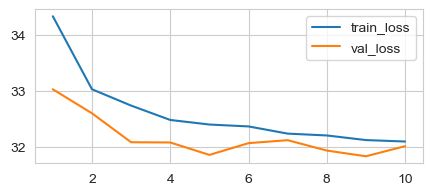

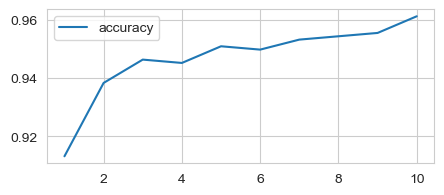

In [147]:
plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(epochs, accuracies_epoch, label='accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [154]:
pred_summary = pd.DataFrame({"label": val_labels, "prediction": val_predictions, "directory": val_directories})
pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]
print(np.where(pred_summary["label"] != pred_summary["prediction"]))
pred_summary

(array([  6,  21,  52,  58, 115, 154, 185, 214, 242, 243, 322, 402, 406,
       451, 500, 547, 553, 554, 565, 595, 598, 612, 713, 730, 741, 751,
       776, 789, 830, 831, 832, 853, 863, 867]),)


,label,prediction,directory,correct
0,0,0,LC500_TAGACTGTCTCTATCALC500,True
1,0,0,LC500_ATTGTGGCAGGTGGTALC500,True
2,0,0,LC500_CTCGCTAGTTGAAGCGLC500,True
3,0,0,LC500_TATTGCTCATTGAACCLC500,True
4,0,0,LC500_CCTTAATAGGCACTAGLC500,True
...,...,...,...,...
870,0,0,LC500_TAGGAGGTCAGGGTTTLC500,True
871,0,0,LC500_GATCATGTCCACCTACLC500,True
872,1,1,LC499_GGTCATACAACGACAGLC499,True
873,0,0,LC500_TTGACGATCGGAGTTTLC500,True


In [162]:
conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
precision = precision_score(pred_summary["label"], pred_summary["prediction"])
recall = recall_score(pred_summary["label"], pred_summary["prediction"])
f1 = f1_score(pred_summary["label"], pred_summary["prediction"])
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")
pd.DataFrame(conf_matrix, index=["True Negative", "True Positive"], columns=["Predicted Negative", "Predicted Positive"])

Accuracy: 0.96
Precision: 0.95
Sensitivity: 0.93
Specificity: 0.98
F1 Score: 0.94


,Predicted Negative,Predicted Positive
True Negative,567,14
True Positive,20,274
